In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
# Read in data
data = pd.read_csv("seekers_iso_pop_econ_fips_gdelt_NEXT_YEAR.csv")

In [17]:
# Create current_population feature
curr_pop_list = []
for index, row in data.iterrows():
    curr_year = str(int(row.Year))
    curr_pop = row[curr_year]
    curr_pop_list.append(curr_pop)
data['current_population']=curr_pop_list

In [18]:
# Remove N/A's in Gdelt fields and current_population (these are mismatched countries, bad records anyways)
print(data.shape)
data = data.dropna(subset=['QuadClass','NuMentions','current_population'])

# Remove N/A's in economic data (hopefully we'll fill some of these)
data = data.dropna(subset=['Unemployment Rate',
                           'GDP Per Capita',
                           'Life expectancy',])

data.shape

(2983, 101)


(2983, 101)

In [130]:
# Create y vector, 2000-2017
years = np.arange(2011,2014)
y = data.loc[data.Year.isin(years),'applied_next_year']
prv_year_pop = data.loc[data.Year.isin(years),'current_population']

y = y/prv_year_pop

# Create X feature matrix, including only the columns that we want to predict on in feature_list
feature_list = [
    'Applied during year',
    'current_population',
    'Unemployment Rate',
    'GDP Per Capita',
    'Life expectancy',
    'GoldsteinScale',
    'NuMentions',
    'AvgTone',
    'QuadClass',
]
X = data.loc[data.Year.isin(years),feature_list]


In [131]:
# Check for columns with N/A's and count the N/A's
for col in X:
    if X[col].isna().any():
        print(col,X[col].value_counts(dropna=False))
        

In [132]:
# Modeling!
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

# Normalize X and y
# Note: I'm normalizing (setting mean to 0) not standardizing (setting variance to 1)
transformer = Normalizer().fit(X)
X_norm = transformer.transform(X)
y_norm = y / y.mean()

#Train_test_split, post-normalizing
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2)

In [133]:
# Function for trying out models
def test_reg(reg,X_train, X_test, y_train, y_test,return_reg=False):
    '''test_reg takes a regressor object and the 4 data sets, trains the regressor, makes predictions
    on the test set, and prints an r^2 score.  Returns trained regressor if return_reg=True.'''
    reg.fit(X_train,y_train)
    preds = reg.predict(X_test)
    print(reg,"\nr^2: ",r2_score(y_test,preds),"\n")
    if return_reg:
        return reg

# Instantiate the regressors
LR_reg = linear_model.LinearRegression()
EN_reg = linear_model.ElasticNetCV(cv=10)
DT_reg = tree.DecisionTreeRegressor()
RF_reg = ensemble.RandomForestRegressor()

# Train and test all models with default settings
for model in [LR_reg,EN_reg,DT_reg,RF_reg]:
    test_reg(model,X_train, X_test, y_train, y_test) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
r^2:  0.8605597614763432 

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0) 
r^2:  0.02497999327978151 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') 
r^2:  0.6132397137150952 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impu

/Users/gmholden/workspace/.venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [134]:
# Random Forest provides feature_importance...not rock solid, but useful for some context
RF_reg.fit(X_train,y_train)

for name,imp in zip(X.columns,RF_reg.feature_importances_):
    print("{}: {:2.2}".format(name,imp))

Applied during year: 0.85
current_population: 0.019
Unemployment Rate: 0.032
GDP Per Capita: 0.022
Life expectancy: 0.014
GoldsteinScale: 0.038
NuMentions: 0.0092
AvgTone: 0.01
QuadClass: 0.0037


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
r^2:  0.5094748327577963 



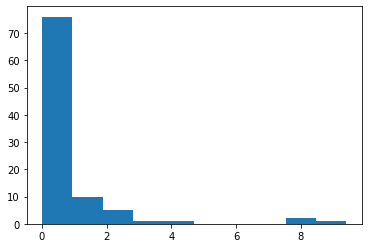

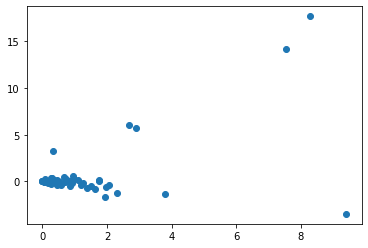

In [135]:

reg = RF_reg
reg.fit(X_train,y_train)
preds = reg.predict(X_test)
print(reg,"\nr^2: ",r2_score(y_test,preds),"\n")
plt.figure(0)
plt.hist(preds)

residuals = y_test-preds
plt.figure(1)
plt.scatter(preds, residuals)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best') 
r^2:  0.6010548132620972 



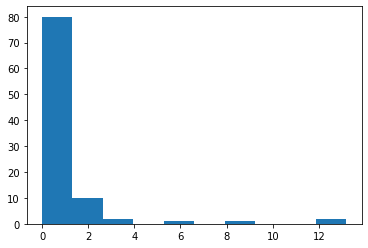

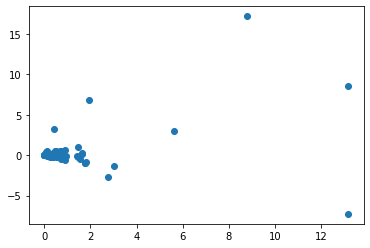

In [136]:
reg = DT_reg
reg.fit(X_train,y_train)
preds = reg.predict(X_test)
print(reg,"\nr^2: ",r2_score(y_test,preds),"\n")
plt.figure(0)
plt.hist(preds)

residuals = y_test-preds
plt.figure(1)
plt.scatter(preds, residuals)